# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

### Thomas Smith

This notebook follows the template provided by Udacity to implement traffic sign recogntion.

First, the dataset is imported and explored. We then augment the dataset to improve the distribution of images across classes, and to increase the total number of training examples.  The dataset is normalised before a variety of network architectures are used to train and validate a model against the training and validation sets. The model that performs best against the dataset is then used to evaluate the test set. Finally, additional test images are sourced from the internet and used to further investigate the performance of the trained model.

In [1]:
%%capture
import os

from random import randint, uniform
import csv
from math import ceil
from IPython.display import clear_output

import pickle
import numpy as np
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow.keras.layers import Flatten as flatten
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cv2 
from skimage.util import random_noise
from textwrap import wrap

# Visualizations will be shown in the notebook.
%matplotlib inline

In [2]:
%load_ext tensorboard.notebook
LOGDIR = './logs/'
# !rm -rf ./logs/

---
## Step 0: Load The Data

In [3]:
# Load pickled data

training_file = './traffic-signs-data/train.p'
validation_file= './traffic-signs-data/valid.p'
testing_file = './traffic-signs-data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train, imgsize_train, coords_train = train['features'], train['labels'], train['sizes'], train['coords']
X_valid, y_valid, imgsize_valid, coords_valid = valid['features'], valid['labels'], valid['sizes'], valid['coords']
X_test, y_test, imgsize_test, coords_test = test['features'], test['labels'], test['sizes'], test['coords']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below. Use python, numpy and/or pandas methods to calculate the data summary rather than hard coding the results. For example, the [pandas shape method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.shape.html) might be useful for calculating some of the summary results. 

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [4]:
### Replace each question mark with the appropriate value. 
### Use python, pandas or numpy methods rather than hard coding the results

# TODO: Number of training examples
n_train = len(y_train)

# TODO: Number of validation examples
n_validation = len(y_valid)

# TODO: Number of testing examples.
n_test = len(y_test)

# TODO: What's the shape of an traffic sign image?
image_shape = X_train[0].shape

# TODO: How many unique classes/labels there are in the dataset.
n_classes = len(np.unique(y_train))

print("Number of training examples =", n_train)
print("Number of validation examples =", n_validation)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Include an exploratory visualization of the dataset

Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc. 

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections. It can be interesting to look at the distribution of classes in the training, validation and test set. Is the distribution the same? Are there more examples of some classes than others?

### Create dictionary for cross referencing sign class IDs

In [5]:
### Data exploration visualization code goes here.
### Feel free to use as many code cells as needed.

reader = csv.reader(open('signnames.csv', 'r'))

# make sign names dictionary for cross referencing sign class IDs. Header row is skipped
signnames_dict = {int(row[0]): str(row[1]) for i, row in enumerate(reader) if i > 0}

### Example traffc signs from training dataset

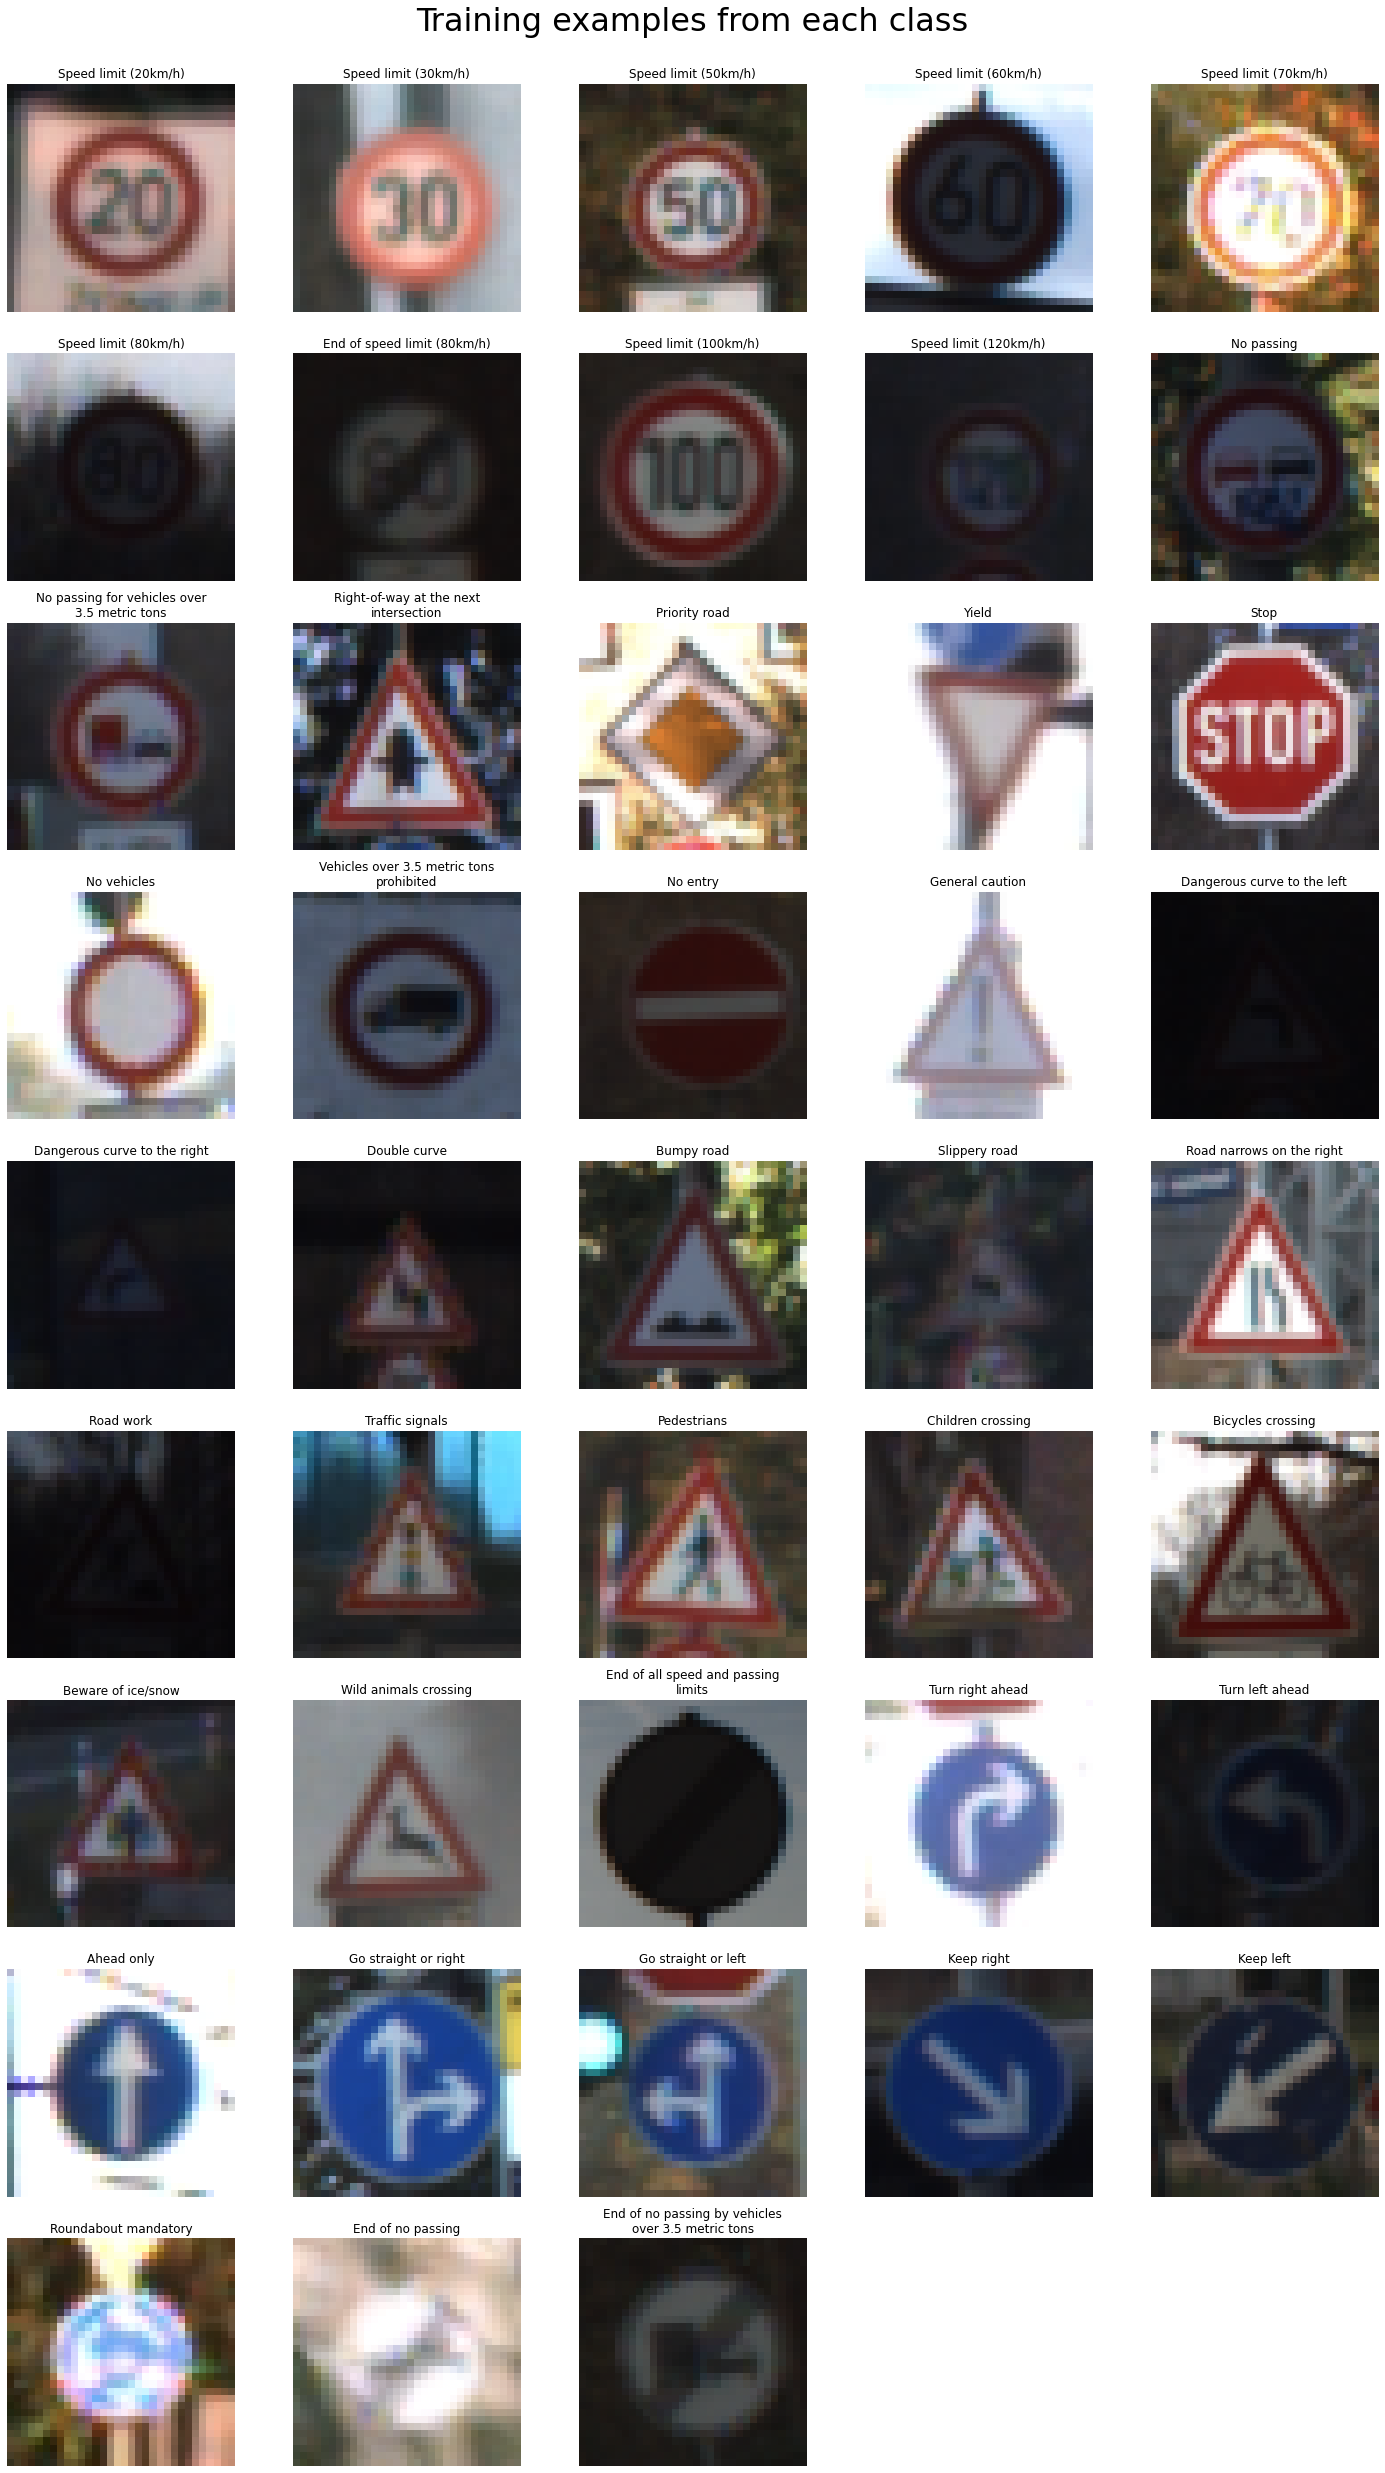

In [60]:
class_ex = []

for c in range(n_classes):
    c_ind = np.nonzero([y_train == c])[1]
    r = randint(0, len(c_ind))
    class_ex.append(X_train[c_ind[r]])
cols = 5
rows = ceil(len(class_ex) / cols)
fig = plt.figure(figsize=(20,35))
fig.suptitle('Training examples from each class', fontsize=32);
for ex in range(len(class_ex)):
    ax = fig.add_subplot(rows, cols, ex+1)
    ax.imshow(class_ex[ex])
    ax.set_title('\n'.join(wrap(signnames_dict[ex],30)))
    ax.axis('Off')
fig.tight_layout(rect=[0,0,1,0.96])   
fig.savefig('./writeup_images/img_all_classes.png')

### Quantity of training, validation and test images by traffic sign type 

In [7]:
bars_train = []
bars_valid = []
bars_test = []

for class_id in range(0, n_classes):
    bars_train.append((y_train == class_id).sum())
    bars_valid.append((y_valid == class_id).sum())
    bars_test.append((y_test == class_id).sum())

bars_train = np.array(bars_train)
bars_valid = np.array(bars_valid)
bars_test = np.array(bars_test)

avg_train_ex = int(np.mean(bars_train))
std_train_ex = int(np.std(bars_train))

print('Training images in each class: \n  Average: {} \n  Standard Deviation: {} \n  Min: {} \n  Max: {}'
      .format(avg_train_ex, std_train_ex, np.min(bars_train), np.max(bars_train)))

Training images in each class: 
  Average: 809 
  Standard Deviation: 619 
  Min: 180 
  Max: 2010


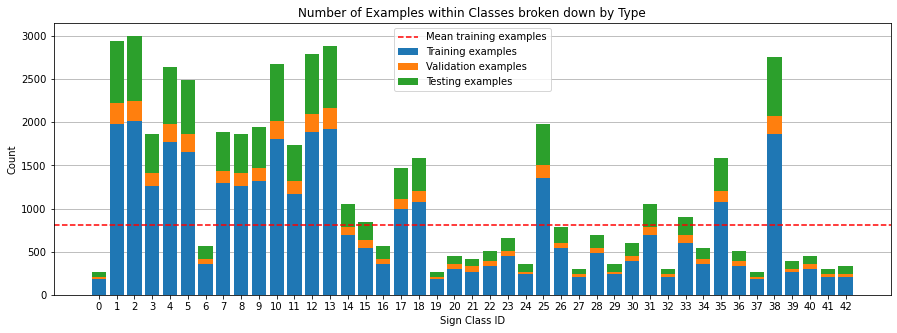

In [61]:
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(111)
ax.grid(axis='y')
ax.set_axisbelow(True)
ax.set_title('Number of Examples within Classes broken down by Type')
ax.bar(range(0, n_classes), bars_train, label='Training examples')
ax.bar(range(0, n_classes), bars_valid, bottom=bars_train, label='Validation examples')
ax.bar(range(0, n_classes), bars_test, bottom=bars_train+bars_valid, label='Testing examples')
ax.axhline(avg_train_ex, ls='dashed', color='r', label='Mean training examples')
ax.set_xticks(range(0, n_classes))
ax.set
ax.legend();
ax.set_xlabel('Sign Class ID')
ax.set_ylabel('Count');
fig.savefig('./writeup_images/orig_data_bar.png')

It is apparent from the above graph that the images in the dataset are not evenly distribution across all of the classes. There is an average of 809 training images for each class, but lowest number of training images in a class is only 180. 

The large range in the distribution of images over the classes could lead to bias in the learnt model, where some classes are better represented and therefore more likely to be correctly classified. In addition, 180 examples may not be sufficient to train the model to classify the class.

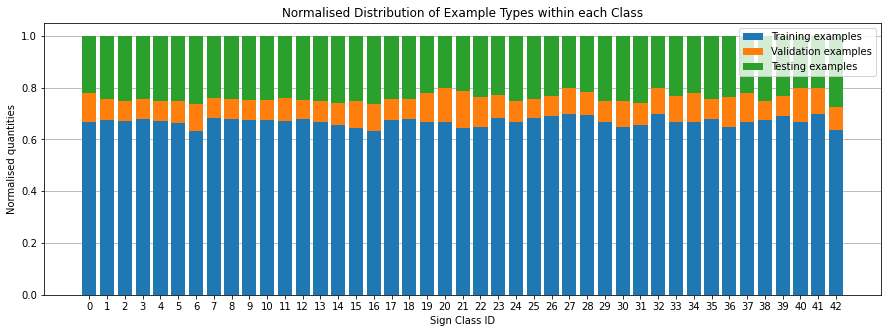

In [62]:
bars_total = bars_train + bars_valid + bars_test
bars_train_norm = bars_train / bars_total
bars_valid_norm = bars_valid / bars_total
bars_test_norm = bars_test / bars_total

fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(111)
ax.set_title('Normalised Distribution of Example Types within each Class')
ax.grid(axis='y')
ax.set_axisbelow(True)
ax.bar(range(0, n_classes), bars_train_norm, label='Training examples')
ax.bar(range(0, n_classes), bars_valid_norm, bottom=bars_train_norm, label='Validation examples')
ax.bar(range(0, n_classes), bars_test_norm, bottom=bars_train_norm+bars_valid_norm, label='Testing examples')
ax.set_xticks(range(0, n_classes))
ax.set
ax.legend();
ax.set_xlabel('Sign Class ID')
ax.set_ylabel('Normalised quantities');
fig.savefig('./writeup_images/normal_bar.png')

Looking at the distribution of images within each class, it is apparent that each class is fairly similarly distributed, with approximately 65% of the images in each class being in the training set, 5% in the validation set and 20% in the testing set.

## Augment Train Dataset

To improve model learning the dataset is augmented to both increase the absolute number of training examples in each class and to reduce the variation in numbers of training images across the classes.

### Image Transforms

Some image class datasets can be augmented by performing various transorms to the images.

Some images can be flipped horizontally (i.e about the y axis) and still belong to the original class:

In [10]:
def flip_hor(src):
    return np.flip(src,1)

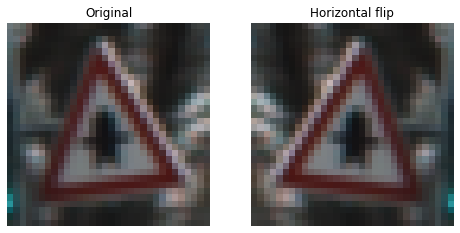

In [64]:
c_ind = np.nonzero([y_train == 11])[1]
r = randint(0, len(c_ind))
src = X_train[c_ind[r]]
dst = flip_hor(src)

fig = plt.figure(figsize=(8,4))
ax1 = fig.add_subplot(121)
ax1.imshow(src)
ax1.axis('Off')
ax1.set_title('Original')
ax2 = fig.add_subplot(122)
ax2.imshow(dst)
ax2.axis('Off')
ax2.set_title('Horizontal flip');
fig.savefig('./writeup_images/hor_flip.png')

Some images can be flipped vertically (i.e. about the x axis) and still belong to the original class:

In [12]:
def flip_vert(src):
    return np.flip(src,0)

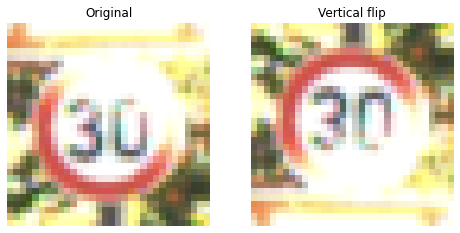

In [63]:
c_ind = np.nonzero([y_train == 1])[1]
r = randint(0, len(c_ind))
src = X_train[c_ind[r]]
dst = flip_vert(src)

fig = plt.figure(figsize=(8,4))
ax1 = fig.add_subplot(121)
ax1.imshow(src)
ax1.axis('Off')
ax1.set_title('Original')
ax2 = fig.add_subplot(122)
ax2.imshow(dst)
ax2.axis('Off')
ax2.set_title('Vertical flip');
fig.savefig('./writeup_images/vert_flip.png')

Some images can be flipped both horizontally and vertically. In addition, these images can be rotated 180<sup>o</sup>, achieved by rotated horizontally and then vertically:

In [14]:
def rotate_180(src):
    return flip_hor(flip_vert(src))

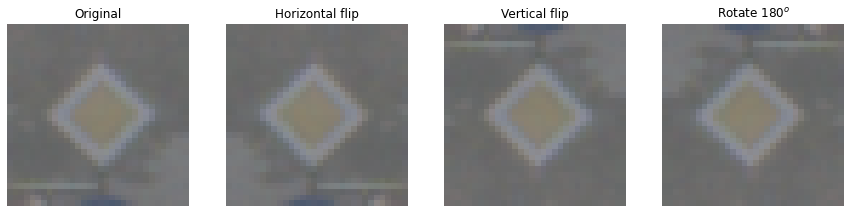

In [65]:
c_ind = np.nonzero([y_train == 12])[1]
r = randint(0, len(c_ind))
src = X_train[c_ind[r]]
dst_hor = flip_hor(src)
dst_vert = flip_vert(src)
dst_180 = rotate_180(src)

fig = plt.figure(figsize=(15,4))
ax1 = fig.add_subplot(141)
ax1.imshow(src)
ax1.axis('Off')
ax1.set_title('Original')
ax2 = fig.add_subplot(142)
ax2.imshow(dst_hor)
ax2.axis('Off')
ax2.set_title('Horizontal flip')
ax3 = fig.add_subplot(143)
ax3.imshow(dst_vert)
ax3.axis('Off')
ax3.set_title('Vertical flip');
ax4 = fig.add_subplot(144)
ax4.imshow(dst_180)
ax4.axis('Off')
ax4.set_title('Rotate $180^o$');

Some images can be rotated 180<sup>o</sup>:

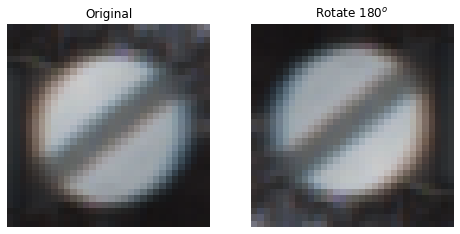

In [66]:
c_ind = np.nonzero([y_train == 32])[1]
r = randint(0, len(c_ind))
src = X_train[c_ind[r]]
dst_180 = rotate_180(src)

fig = plt.figure(figsize=(8,4))
ax1 = fig.add_subplot(121)
ax1.imshow(src)
ax1.axis('Off')
ax1.set_title('Original')
ax2 = fig.add_subplot(122)
ax2.imshow(dst_180)
ax2.axis('Off')
ax2.set_title('Rotate $180^o$');
fig.savefig('./writeup_images/180.png')

Lastly, some images can be flipped horizontally but the flipped image belongs to a different class:

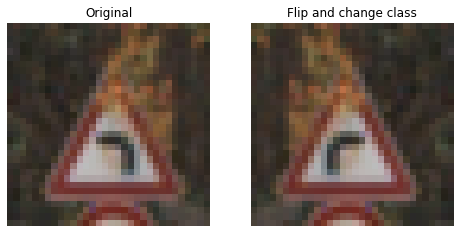

In [67]:
c_ind = np.nonzero([y_train == 19])[1]
r = randint(0, len(c_ind))
src = X_train[c_ind[r]]
dst = flip_hor(src)

fig = plt.figure(figsize=(8,4))
ax1 = fig.add_subplot(121)
ax1.imshow(src)
ax1.axis('Off')
ax1.set_title('Original')
ax2 = fig.add_subplot(122)
ax2.imshow(dst)
ax2.axis('Off')
ax2.set_title('Flip and change class');
fig.savefig('./writeup_images/flip_swap.png')

Applying these transforms as appropriate to augment the training dataset:

```python
flippable_hor = np.array([11, 12, 13, 15, 17, 18, 22, 26, 30, 35])
flippable_vert = np.array([1, 5, 12, 15, 17])
flippable_180 = np.array([12, 15, 17, 32, 40])
flippable_change = np.array([
    [19, 20],
    [20, 19],
    [33, 34],
    [34, 33],
    [36, 37],
    [37, 36],
    [38, 39],
    [39, 38]
])
```

```python
X_train_trans = np.empty([0, X_train.shape[1], X_train.shape[2], X_train.shape[3]], dtype = np.uint8)
y_train_trans = np.empty(0, dtype = np.uint8)

for c in range(n_classes):
    if c in flippable_hor or c in flippable_vert or c in flippable_180 or c in flippable_change:
        c_set = X_train[np.nonzero([y_train == c])[1]]
        if c in flippable_hor:
            for img in c_set:
                X_train_trans = np.append(X_train_trans, [flip_hor(img)], axis=0)
                y_train_trans = np.append(y_train_trans, [c], axis=0)
        if c in flippable_vert:
            for img in c_set:
                X_train_trans = np.append(X_train_trans, [flip_vert(img)], axis=0)
                y_train_trans = np.append(y_train_trans, [c], axis=0)
        if c in flippable_180:
            for img in c_set:
                X_train_trans = np.append(X_train_trans, [rotate_180(img)], axis=0)
                y_train_trans = np.append(y_train_trans, [c], axis=0)
        if c in flippable_change[:, 0]:
            c_new = flippable_change[flippable_change[:,0] == c, 1]
            for img in c_set:
                X_train_trans = np.append(X_train_trans, [flip_hor(img)], axis=0)
                y_train_trans = np.append(y_train_trans, c_new, axis=0)
```

As the transform process takes some time we save the output:

```python
np.save('./traffic-signs-data/X_train_trans', X_train_trans)
np.save('./traffic-signs-data/y_train_trans', y_train_trans)
```

In [18]:
X_train_trans = np.load('./traffic-signs-data/X_train_trans.npy')
y_train_trans = np.load('./traffic-signs-data/y_train_trans.npy')

In [19]:
len(y_train_trans)

24989

This augmentation approach has increased the number of training examples by 24989

In [20]:
bars_train_trans = []

for class_id in range(0, n_classes):
    bars_train_trans.append((y_train_trans == class_id).sum())

bars_train_trans = np.array(bars_train_trans)
avg_train_ex_new = np.mean(bars_train_trans + bars_train)

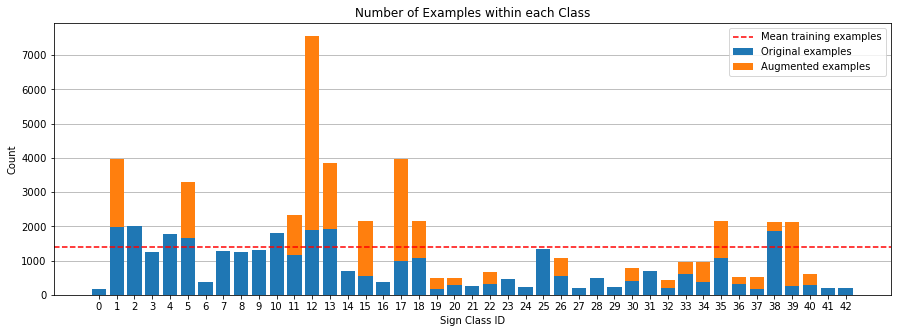

In [68]:
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(111)
ax.grid(axis='y')
ax.set_axisbelow(True)
ax.set_title('Number of Examples within each Class')
ax.bar(range(0, n_classes), bars_train, label='Original examples')
ax.bar(range(0, n_classes), bars_train_trans, bottom=bars_train, label='Augmented examples')
ax.axhline(avg_train_ex_new, ls='dashed', color='r', label='Mean training examples')
ax.set_xticks(range(0, n_classes))
ax.set
ax.legend();
ax.set_xlabel('Sign Class ID')
ax.set_ylabel('Count');
fig.savefig('./writeup_images/transform_bar.png')

Unfortunately it is apparent that many of the classes that were already well represented have been augmented while many of the classes which were underrepresented haven't been increased in size at all. As such, further augmentation is required

Combine the original dataset with the transformed dataset to create an augmented dataset:

In [22]:
X_train_aug = np.concatenate((X_train, X_train_trans), axis=0)
y_train_aug = np.concatenate((y_train, y_train_trans), axis=0)

### Image Jittering

Another technique to augment the training dataset is to 'jitter' the images. This involves making small random changes to the image. In this project I apply rotation, translation and scaling to the images.

In [23]:
def rotate(img, angle):
    rows,cols, _ = img.shape
    M = cv2.getRotationMatrix2D((cols/2,rows/2),angle,1)
    dst = cv2.warpAffine(img,M,(cols,rows))

    return dst

def translate(img, dx, dy):
    rows,cols, _ = img.shape

    M = np.float32([[1,0,dx],[0,1,dy]])
    dst = cv2.warpAffine(img,M,(cols,rows))

    return dst

def scale(img, factor):
    fx, fy = factor, factor
    img_size = img.shape[0]
    img_ctr = img_size//2
    if factor == 1:
        pass
    elif factor < 1:
        # Scale image
        dst = cv2.resize(img, None, fx=fx, fy=fy, interpolation = cv2.INTER_AREA)
        # Pad image back to 32x32
        dst_size = dst.shape[0]
        pad_size = (img_size - dst_size) // 2
        top = pad_size + (dst_size % 2 != 0)
        bottom = pad_size
        left = pad_size + (dst_size % 2 != 0)
        right = pad_size
        dst = cv2.copyMakeBorder(dst, top, bottom, left, right, cv2.BORDER_REPLICATE)
    elif factor > 1:
        # Scale image
        dst = cv2.resize(img, None, fx=fx, fy=fy, interpolation = cv2.INTER_LINEAR)
        # Crop image back to 32x32
        dst_ctr = dst.shape[0]//2
        dst = dst[dst_ctr-img_ctr : dst_ctr+img_ctr, dst_ctr-img_ctr : dst_ctr+img_ctr]
   
    return dst

In [24]:
def gen_img(img):
    dst = scale(img, uniform(0.9,1.1))
    dst = translate(dst, uniform(-2,2),uniform(-2,2))
    dst = rotate(dst, uniform(-5,5))
    
    return dst

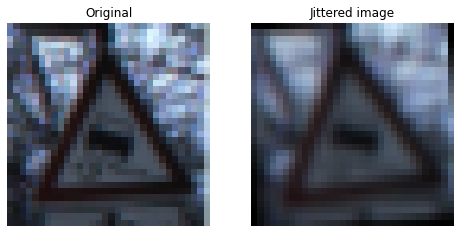

In [70]:
# Demo
src = X_train[randint(0, n_train)].copy()
dst = gen_img(src)

fig = plt.figure(figsize=(8,4))
ax1 = fig.add_subplot(121)
ax1.imshow(src)
ax1.axis('Off')
ax1.set_title('Original')
ax2 = fig.add_subplot(122)
ax2.imshow(dst)
ax2.axis('Off')
ax2.set_title('Jittered image');
fig.savefig('./writeup_images/jitter.png')

```python
X_train_jit = np.copy(X_train_aug)
y_train_jit = np.copy(y_train_aug)

for c in range(n_classes):
    while (y_train_jit == c).sum() < 2000:
        src_imgs = X_train_aug[y_train_aug == c]
        new_imgs = []
        for i, img in enumerate(src_imgs):
            clear_output(wait=True)
            print('Class {} of {}: {:.0%} complete'.format(c+1, n_classes, (y_train_jit == c).sum()/2000))
            new_img = gen_img(img)
            new_imgs.append(new_img)
        X_train_jit = np.concatenate((X_train_jit, new_imgs))
        y_train_jit = np.concatenate((y_train_jit, np.ones(len(new_imgs))*c))
        print()
```

As the image augmenting process takes some time, the final dataset of training images is saved for future use

```python
np.save('./traffic-signs-data/X_train_jit', X_train_jit)
np.save('./traffic-signs-data/y_train_jit', y_train_jit)
```

Loading the final dataset of training images:

In [26]:
X_train_jit = np.load('./traffic-signs-data/X_train_jit.npy')
y_train_jit = np.load('./traffic-signs-data/y_train_jit.npy')

In [27]:
bars_train_jit = []

for c in range(0, n_classes):
    bars_train_jit.append((y_train_jit == c).sum())

bars_train_jit = np.array(bars_train_jit)
avg_train_ex_final = np.mean(bars_train_jit)
std_train_ex_final = np.std(bars_train_jit)

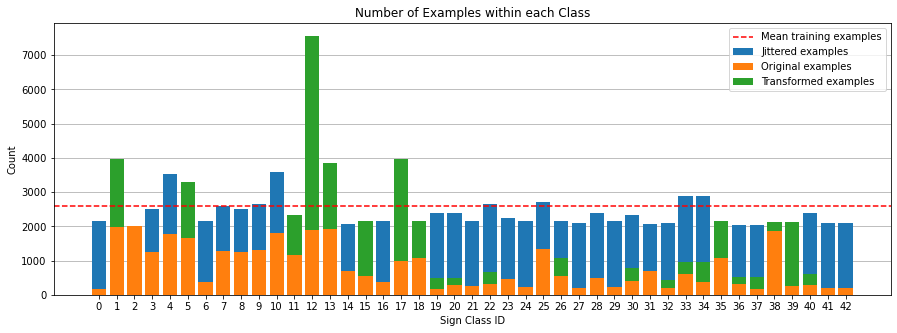

In [71]:
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(111)
ax.grid(axis='y')
ax.set_axisbelow(True)
ax.set_title('Number of Examples within each Class')
ax.bar(range(0, n_classes), bars_train_jit, label='Jittered examples')
ax.bar(range(0, n_classes), bars_train, label='Original examples')
ax.bar(range(0, n_classes), bars_train_trans, bottom=bars_train, label='Transformed examples')
ax.axhline(avg_train_ex_final, ls='dashed', color='r', label='Mean training examples')
ax.set_xticks(range(0, n_classes))
ax.set
ax.legend();
ax.set_xlabel('Sign Class ID')
ax.set_ylabel('Count');
fig.savefig('./writeup_images/jitter_bar.png')

In [29]:
print('Final Dataset: \n  Mean: {} \n  STD: {} \n  Min: {}  \n  Max: {}'
      .format(avg_train_ex_final, std_train_ex_final, np.min(bars_train_jit), np.max(bars_train_jit)))

Final Dataset: 
  Mean: 2607.767441860465 
  STD: 936.6176613704923 
  Min: 2010  
  Max: 7560


The distribution of training images across the classes is now much more even. All class now have at least 2000 training examples.

In [30]:
len(y_train_jit)

112134

There are now 112134 training examples in the dataset

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play! 

With the LeNet-5 solution from the lecture, you should expect a validation set accuracy of about 0.89. To meet specifications, the validation set accuracy will need to be at least 0.93. It is possible to get an even higher accuracy, but 0.93 is the minimum for a successful project submission. 

There are various aspects to consider when thinking about this problem:

- Neural network architecture (is the network over or underfitting?)
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Pre-process the Data Set (normalization, grayscale, etc.)

Minimally, the image data should be normalized so that the data has mean zero and equal variance. For image data, `(pixel - 128)/ 128` is a quick way to approximately normalize the data and can be used in this project. 

Other pre-processing steps are optional. You can try different techniques to see if it improves performance. 

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project.

In [31]:
# Normalise
X_train_norm = X_train_jit / 255

# Center
X_train_cent = X_train_norm - (np.mean(X_train_norm, axis=(1,2,3)))[:, np.newaxis, np.newaxis, np.newaxis]

#Grayscale
X_train_gray = np.mean(X_train_cent, axis=3)[:,:,:,np.newaxis]
all_px = X_train_gray.flatten();

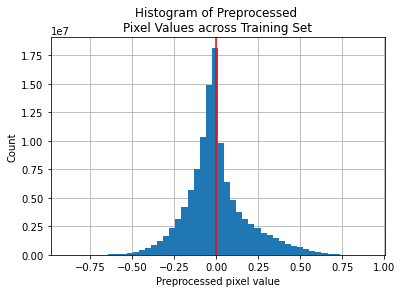

In [72]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.hist(all_px, bins = 50)
ax.axvline(np.mean(X_train_gray),c='r')
ax.set_title('Histogram of Preprocessed \nPixel Values across Training Set')
ax.grid()
ax.set_axisbelow(True)
ax.set_xlabel('Preprocessed pixel value')
ax.set_ylabel('Count');
fig.savefig('./writeup_images/px_dist.png')

In [33]:
# Normalise
X_valid_norm = X_valid / 255

# Center
X_valid_cent = X_valid_norm - (np.mean(X_valid_norm, axis=(1,2,3)))[:, np.newaxis, np.newaxis, np.newaxis]

# Graysclae
X_valid_gray = np.mean(X_valid_cent, axis=3)[:,:,:,np.newaxis]

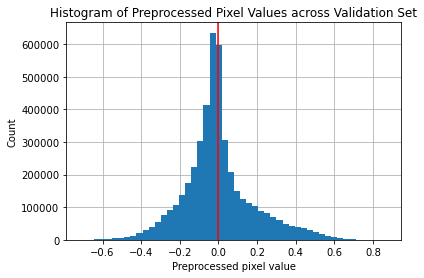

In [34]:
all_px_valid = X_valid_gray.flatten();
fig = plt.figure()
ax = fig.add_subplot(111)
ax.hist(all_px_valid, bins = 50)
ax.axvline(np.mean(X_valid_gray),c='r')
ax.set_title('Histogram of Preprocessed Pixel Values across Validation Set')
ax.grid()
ax.set_axisbelow(True)
ax.set_xlabel('Preprocessed pixel value')
ax.set_ylabel('Count');

In [35]:
# Normalise
X_test_norm = X_test / 255

# Center
X_test_cent = X_test_norm - (np.mean(X_test_norm, axis=(1,2,3)))[:, np.newaxis, np.newaxis, np.newaxis]

# Graysclae
X_test_gray = np.mean(X_test_cent, axis=3)[:,:,:,np.newaxis]

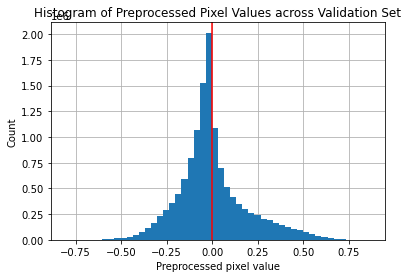

In [36]:
all_px_valid = X_test_gray.flatten();
fig = plt.figure()
ax = fig.add_subplot(111)
ax.hist(all_px_valid, bins = 50)
ax.axvline(np.mean(X_test_gray),c='r')
ax.set_title('Histogram of Preprocessed Pixel Values across Validation Set')
ax.grid()
ax.set_axisbelow(True)
ax.set_xlabel('Preprocessed pixel value')
ax.set_ylabel('Count');

---
# Architecture
## Helper Functions

Define functions for convolutional and dense layers

In [37]:
def conv_layer(x, filter_size, layers_in, layers_out, padding='SAME', name='conv', mu=0, sigma=0.1):
    with tf.name_scope(name):
        w = tf.Variable(tf.truncated_normal([filter_size, filter_size, layers_in, layers_out], mu, sigma,), name='W')
        b = tf.Variable(tf.zeros(layers_out), name='B')
        conv = tf.nn.conv2d(x, w, strides=[1, 1, 1, 1], padding=padding)
        conv = conv + b
        act = tf.nn.relu(conv)
        tf.summary.histogram('weights', w)
        tf.summary.histogram('biases', b)
        tf.summary.histogram('activations', act)
    
        return act

def fc_layer(x, layers_in, layers_out, name='fc', mu=0., sigma=0.1):
    with tf.name_scope(name):
        w = tf.Variable(tf.truncated_normal([layers_in, layers_out], mu, sigma), name='W')
        b = tf.Variable(tf.zeros(layers_out), name='B')
        act = tf.matmul(x, w) + b
        tf.summary.histogram('weights', w)
        tf.summary.histogram('biases', b)
        tf.summary.histogram('activations', act)
    
        return act

In [38]:
def viz_layer(layer):
    # Reshape and translate output of convolution layer for visualization in Tensorboard
    
    ix = int(layer.shape[1])
    iy = int(layer.shape[2])
    channels = int(layer.shape[3])

    viz = tf.slice(layer, (0, 0, 0, 0), (1, -1, -1, -1))  # Take first image
    viz = tf.reshape(viz, (iy, ix, channels))  # Reshape to remove first dimension
    ix += 2  # Padding width
    iy += 2  # Padding height
    viz = tf.image.resize_image_with_crop_or_pad(viz, iy, ix)  # Add padding to image

    cy = 2
    cx = int(channels/2)
    # Reorder so the channels are in the first dimension, x and y follow.
    viz = tf.reshape(viz,(iy,ix,cy,cx)) 
    viz = tf.transpose(viz,(2,0,3,1)) #cy,iy,cx,ix

    # image_summary needs 4d input
    viz = tf.reshape(viz,(1,cy*iy,cx*ix,1))

    return viz

### Architectures

Define a range of architectures for training and validation

In [39]:
def LeNet_valid(x, drop_rate=0.):
    conv1 = conv_layer(x, 5, 3, 6, 'VALID', 'conv1')
    V = viz_layer(conv1)
    tf.summary.image('conv1', V)
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    conv2 = conv_layer(conv1, 5, 6, 16, 'VALID', 'conv2')
    V = viz_layer(conv2)
    tf.summary.image('conv2', V)
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    flat = tf.contrib.layers.flatten(conv2)
    
    fc1 = fc_layer(flat, 400, 120, 'fc1')
    fc1 = tf.nn.relu(fc1)
    fc1 = tf.nn.dropout(fc1, rate=drop_rate)


    fc2 = fc_layer(fc1, 120, 84, 'fc2')
    fc2 = tf.nn.relu(fc2)
    fc2 = tf.nn.dropout(fc2, rate=drop_rate)

    logits = fc_layer(fc2, 84, n_classes, 'logits')
    
    return logits

In [40]:
def LeNet_gray_valid(x, drop_rate=0.):
    conv1 = conv_layer(x, 5, 1, 6, 'VALID', 'conv1')
    V = viz_layer(conv1)
    tf.summary.image('conv1', V)
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    conv2 = conv_layer(conv1, 5, 6, 16, 'VALID', 'conv2')
    V = viz_layer(conv2)
    tf.summary.image('conv2', V)
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    flat = tf.contrib.layers.flatten(conv2)
    
    fc1 = fc_layer(flat, 400, 120, 'fc1')
    fc1 = tf.nn.relu(fc1)
    fc1 = tf.nn.dropout(fc1, rate=drop_rate)


    fc2 = fc_layer(fc1, 120, 84, 'fc2')
    fc2 = tf.nn.relu(fc2)
    fc2 = tf.nn.dropout(fc2, rate=drop_rate)

    logits = fc_layer(fc2, 84, n_classes, 'logits')
    
    return logits

In [41]:
def LeNet_same(x, drop_rate=0.):
    conv1 = conv_layer(x, 5, 3, 6, 'SAME', 'conv1')
    V = viz_layer(conv1)
    tf.summary.image('conv1', V)
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

    conv2 = conv_layer(conv1, 5, 6, 16, 'SAME', 'conv2')
    V = viz_layer(conv2)
    tf.summary.image('conv2', V)
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

    flat = tf.contrib.layers.flatten(conv2)
    
    fc1 = fc_layer(flat, 1024, 400, 'fc1')
    fc1 = tf.nn.relu(fc1)
    fc1 = tf.nn.dropout(fc1, rate=drop_rate)


    fc2 = fc_layer(fc1, 400, 84, 'fc2')
    fc2 = tf.nn.relu(fc2)
    fc2 = tf.nn.dropout(fc2, rate=drop_rate)

    logits = fc_layer(fc2, 84, n_classes, 'logits')
    
    return logits

In [42]:
def LeNet_gray_same(x, drop_rate=0.):
    conv1 = conv_layer(x, 5, 1, 6, 'SAME', 'conv1')
    V = viz_layer(conv1)
    tf.summary.image('conv1', V)
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

    conv2 = conv_layer(conv1, 5, 6, 16, 'SAME', 'conv2')
    V = viz_layer(conv2)
    tf.summary.image('conv2', V)
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

    flat = tf.contrib.layers.flatten(conv2)
    
    fc1 = fc_layer(flat, 1024, 400, 'fc1')
    fc1 = tf.nn.relu(fc1)
    fc1 = tf.nn.dropout(fc1, rate=drop_rate)


    fc2 = fc_layer(fc1, 400, 84, 'fc2')
    fc2 = tf.nn.relu(fc2)
    fc2 = tf.nn.dropout(fc2, rate=drop_rate)

    logits = fc_layer(fc2, 84, n_classes, 'logits')
    
    return logits

In [43]:
def deepConv(x, drop_rate=None):
    conv1 = conv_layer(x, 5, 3, 6, 'SAME', 'conv1')
    V = viz_layer(conv1)
    tf.summary.image('conv1', V)    
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

    conv2 = conv_layer(conv1, 5, 6, 12, 'SAME', 'conv2')
    V = viz_layer(conv2)
    tf.summary.image('conv2', V)    
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

    conv3 = conv_layer(conv2, 5, 12, 24, 'SAME', 'conv3')
    V = viz_layer(conv3)
    tf.summary.image('conv3', V)    
    conv3 = tf.nn.max_pool(conv3, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
   
    conv4 = conv_layer(conv3, 5, 24, 48, 'SAME', 'conv4')
    V = viz_layer(conv4)
    tf.summary.image('conv4', V)        
    conv4 = tf.nn.max_pool(conv4, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

    conv5 = conv_layer(conv4, 5, 48, 96, 'SAME', 'conv5')
    V = viz_layer(conv5)
    tf.summary.image('conv5', V)   
    conv5 = tf.nn.max_pool(conv5, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    
    flat = tf.contrib.layers.flatten(conv5)
    logits = fc_layer(flat, 96, n_classes, 'logits')
    
    return logits

In [44]:
def GAP(x, drop_rate=None):
    conv1 = conv_layer(x, 5, 3, 6, 'SAME', 'conv1')
    V = viz_layer(conv1)
    tf.summary.image('conv1', V)    

    conv2 = conv_layer(conv1, 5, 6, 18, 'SAME', 'conv2')
    V = viz_layer(conv2)
    tf.summary.image('conv2', V)    

    conv3 = conv_layer(conv2, 5, 18, 43, 'SAME', 'conv3')

    logits = tf.reduce_mean(conv3, axis=[1,2])
    logits = tf.contrib.layers.flatten(logits)

    return logits

In [45]:
def GAP2(x, drop_rate=None):
    conv1 = conv_layer(x, 5, 3, 18, 'SAME', 'conv1')
    V = viz_layer(conv1)
    tf.summary.image('conv1', V)    

    conv2 = conv_layer(conv1, 5, 18, 43, 'SAME', 'conv2')

    logits = tf.reduce_mean(conv2, axis=[1,2])
    logits = tf.contrib.layers.flatten(logits)

    return logits

In [46]:
def two_stage(x, drop_rate=0.):
# - Trunk
    # 32x32x3
    conv1 = conv_layer(x, 5, 3, 6, 'SAME', 'conv1')
    V = viz_layer(conv1)
    tf.summary.image('conv1', V)
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    # 16x16x6
    
# - Trunk splits
    # - First branch
    # 16x16x6
    conv2 = conv_layer(conv1, 5, 6, 16, 'SAME', 'conv2')
    V = viz_layer(conv2)
    tf.summary.image('conv2', V)
    # 16x16x16
    conv3 = conv_layer(conv2, 5, 16, 32, 'SAME', 'conv3')
    V = viz_layer(conv3)
    tf.summary.image('conv3', V)
    # 16x16x32
    GAP = tf.reduce_mean(conv3, axis=[1,2])
    GAP = tf.contrib.layers.flatten(GAP)
    # 32
    
    # - Second branch
    # 16x16x6
    branch2 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    # 8x8x6
    flat1 = tf.contrib.layers.flatten(branch2)
    # 384
    fc1 = fc_layer(flat1, 384, 120)
    fc1 = tf.nn.relu(fc1)
    fc1 = tf.nn.dropout(fc1, rate=drop_rate)
    # 120
    
# - Branches merge
    merge = tf.concat([GAP, fc1], 1)
    # 152    
    logits = fc_layer(merge, 152, n_classes, 'logits')
    
    return logits

In [47]:
def two_stage_2(x, drop_rate=None):
# - Trunk
    # 32x32x3
    conv1 = conv_layer(x, 5, 3, 6, 'SAME', 'conv1')
    V = viz_layer(conv1)
    tf.summary.image('conv1', V)
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    # 16x16x6
    
# - Trunk splits
    # - First branch
    # 16x16x6
    conv2 = conv_layer(conv1, 5, 6, 16, 'SAME', 'conv2')
    V = viz_layer(conv2)
    tf.summary.image('conv2', V)
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')    
    # 8x8x16
    flat1 = tf.contrib.layers.flatten(conv2)
    # 1024
    
    # - Second branch
    # 16x16x6
    branch2 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    # 8x8x6
    flat2 = tf.contrib.layers.flatten(branch2)
    # 384

    
# - Branches merge
    merge = tf.concat([flat1, flat2], 1)
    # 1408    
    logits = fc_layer(merge, 1408, n_classes, 'logits')
    
    return logits

In [48]:
def two_stage_2_gray(x, drop_rate=0.):
# - Trunk
    # 32x32x3
    conv1 = conv_layer(x, 5, 1, 6, 'SAME', 'conv1')
    V = viz_layer(conv1)
    tf.summary.image('conv1', V)
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    conv1 = tf.nn.dropout(conv1, rate=drop_rate)
    # 16x16x6


# - Trunk splits
    # - First branch
    # 16x16x6
    conv2 = conv_layer(conv1, 5, 6, 16, 'SAME', 'conv2')
    V = viz_layer(conv2)
    tf.summary.image('conv2', V)
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')    
    conv2 = tf.nn.dropout(conv2, rate=drop_rate)
    # 8x8x16
    
    flat1 = tf.contrib.layers.flatten(conv2)
    # 1024
    
    # - Second branch
    # 16x16x6
    branch2 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    branch2 = tf.nn.dropout(branch2, rate=drop_rate)

    # 8x8x6
    flat2 = tf.contrib.layers.flatten(branch2)
    # 384

    
# - Branches merge
    merge = tf.concat([flat1, flat2], 1)
    # 1408    
    logits = fc_layer(merge, 1408, n_classes, 'logits')
    
    return logits

---
## Pipeline

In [49]:
def train(architecture, train_x, train_y, valid_x, valid_y, drop_rate, n_classes, rate, epochs, dataset, batch_size=512):
    model_string = '{!s}-lr={:.0E}-e={:d}-drop={}-{}'.format(architecture.__name__, rate, epochs, drop_rate, dataset)
    train_writer = tf.summary.FileWriter(LOGDIR + model_string + '-training')
    valid_writer = tf.summary.FileWriter(LOGDIR + model_string + '-validation')
    
    x = tf.placeholder(tf.float32, (None, 32, 32, train_x.shape[-1]), name='inputs')
    y = tf.placeholder(tf.int32, (None), name='labels')
    drop_prob = tf.placeholder(tf.float32, name='drop_prob')
    one_hot_y = tf.one_hot(y, n_classes)
    num_examples = len(train_y)
    num_valid = len(valid_y)

    logits = architecture(x, drop_prob)

    with tf.name_scope('probabilities'):
        softmax = tf.nn.softmax(logits)
        tf.summary.histogram('probabilities', softmax)
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
    with tf.name_scope('loss'):
        loss_operation = tf.reduce_mean(cross_entropy)
        tf.summary.scalar('loss', loss_operation)
    with tf.name_scope('trainer'):
        optimizer = tf.train.AdamOptimizer(learning_rate = rate)
        training_operation = optimizer.minimize(loss_operation)
    with tf.name_scope('accuracy'):
        correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
        accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
        tf.summary.scalar('accuracy', accuracy_operation)

    summary_merge = tf.summary.merge_all()
    saver = tf.train.Saver()
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        train_writer.add_graph(sess.graph)

        print('Training "{}"...'.format(model_string))
        print()
        for epoch in range(epochs):
            total_accuracy = 0
            Xx_train, yy_train = shuffle(train_x, train_y)
            Xx_valid, yy_valid = shuffle(valid_x, valid_y)
            # Train
            for offset in range(0, num_examples, batch_size):
                end = offset + batch_size
                batch_x, batch_y = Xx_train[offset:end], yy_train[offset:end]
                _, train_accuracy, s = sess.run(
                    [training_operation, accuracy_operation, summary_merge],
                    feed_dict={x: batch_x, y: batch_y, drop_prob: drop_rate})
                total_accuracy += (train_accuracy * len(batch_x))
                train_writer.add_summary(s, epoch)
            train_accuracy = total_accuracy / num_examples

            # Validate
            total_accuracy = 0
            for offset in range(0, num_valid, batch_size):
                end = offset + batch_size
                batch_x, batch_y = Xx_valid[offset:end], yy_valid[offset:end]
                valid_accuracy, s = sess.run(
                    [accuracy_operation, summary_merge],
                    feed_dict={x: batch_x, y: batch_y, drop_prob: 0.})
                total_accuracy += (valid_accuracy * len(batch_x))
                valid_writer.add_summary(s, epoch)
            validation_accuracy =  total_accuracy / num_valid

            saver.save(sess, os.path.join(LOGDIR, '{}.ckpt'.format(model_string)), epoch)
            
            print('EPOCH {} ...'.format(epoch+1))
            print('Train Accuracy = {:.3f}'.format(train_accuracy))
            print("Validation Accuracy = {:.3f}".format(validation_accuracy))

        print('Model "{}" Trained'.format(model_string))
        print('\n----------------------------------------\n')

```python
tf.reset_default_graph()
train(
    architecture = LeNet_gray_same,
    train_x = X_train_gray,
    train_y = y_train_jit,
    valid_x = X_valid_gray,
    valid_y = y_valid,
    drop_rate = 0.5,
    n_classes = n_classes,
    rate = 0.001,
    epochs = 50,
    dataset = 'jit-gray-norm',
    batch_size = 256
)
```

```python
tf.reset_default_graph()
train(
    architecture = LeNet_valid,
    train_x = X_train_cent,
    train_y = y_train_jit,
    valid_x = X_valid_cent,
    valid_y = y_valid,
    drop_rate = 0.5,
    n_classes = n_classes,
    rate = 0.001,
    epochs = 50,
    dataset = 'jit-color-norm',
    batch_size = 256
)
```

In [50]:
tf.reset_default_graph()
train(
    architecture = LeNet_gray_valid,
    train_x = X_train_gray,
    train_y = y_train_jit,
    valid_x = X_valid_gray,
    valid_y = y_valid,
    drop_rate = 0.5,
    n_classes = n_classes,
    rate = 0.001,
    epochs = 50,
    dataset = 'jit-gray-norm',
    batch_size = 256
)


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Training "LeNet_gray_valid-lr=1E-03-e=50-drop=0.5-jit-gray-norm"...

EPOCH 1 ...
Train Accuracy = 0.377
Validation Accuracy = 0.746
EPOCH 2 ...
Train Accuracy = 0.664
Validation Accuracy = 0.871
EPOCH 3 ...
Train Accuracy = 0.758
Validation Accuracy = 0.910
EPOCH 4 ...
Train Accuracy = 0.806
Validation Accuracy = 0.922
EPOCH 5 ...
Train Accuracy = 0.831
Validation Accuracy = 0.931
EPOCH 6 ...
Train Accuracy = 0.853
Validation Accuracy = 0.943
EPOCH 7 ...
Train Accuracy = 0.870
Validation Accuracy = 0.950
EPOCH 8 ...
Train Accuracy = 0.882
Validation Accuracy = 0.953
EPOCH 9 ...
Train Accuracy = 0.891
Validation Accuracy = 0.955
EPOCH 10 ...
Train Accuracy = 0.899
Validation Accuracy = 0.958
EPOCH 11 ...
Train Accuracy = 0.907
Validation Accuracy = 0.957


```python
tf.reset_default_graph()
train(
    architecture = two_stage_2_gray,
    train_x = X_train_gray,
    train_y = y_train_jit,
    valid_x = X_valid_gray,
    valid_y = y_valid,
    drop_rate = 0.2,
    n_classes = n_classes,
    rate = 0.001,
    epochs = 50,
    dataset = 'jit-gray-norm',
    batch_size = 256
)
```

```python
tf.reset_default_graph()
train(
    architecture = two_stage_2_gray,
    train_x = X_train_gray,
    train_y = y_train_jit,
    valid_x = X_valid_gray,
    valid_y = y_valid,
    drop_rate = 0.4,
    n_classes = n_classes,
    rate = 0.001,
    epochs = 50,
    dataset = 'jit-gray-norm',
    batch_size = 256
)
```

### Tensorboard Logs

In [51]:
%tensorboard --logdir logs

## Evaluation against Test Set

In [52]:
tf.reset_default_graph()
saver = tf.train.import_meta_graph('./logs/LeNet_gray_valid-lr=1E-03-e=50-drop=0.5-jit-color-norm.ckpt-49.meta')

with tf.Session() as sess:

    saver.restore(sess, './logs/LeNet_gray_valid-lr=1E-03-e=50-drop=0.5-jit-color-norm.ckpt-49')
    graph = tf.get_default_graph()
    
    with graph.as_default():
        print('TESTING...')
        print()
        total_accuracy = 0
        for offset in range(0, len(y_test), 256):
            end = offset + 256
            batch_x, batch_y = X_test_gray[offset:end], y_test[offset:end]
            
            batch_accuracy = sess.run(
                'accuracy/Mean:0', 
                feed_dict={'inputs:0': batch_x, 'labels:0': batch_y, 'drop_prob:0': 0.})
            total_accuracy += (batch_accuracy * len(batch_x))
        test_accuracy = total_accuracy / len(y_test)

#         print('Prediction: {}'.format(signnames_dict[prediction]))
        print('Test Accuracy: {:.02%}'.format(test_accuracy))
#         print(top5)

TESTING...

Test Accuracy: 95.24%


---

## Step 3: Test a Model on New Images

Use the trained model to predict the sign type for German traffic signs from the internet

### Load and Output the Images

Load images

In [53]:
### Load the images and plot them here.
inputfolder = './traffic-sign-examples/'
new_imgs = []
i=1
for file in os.listdir(inputfolder):
    img = cv2.imread(os.path.join(inputfolder,file))
    if img is not None:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (32, 32), interpolation = cv2.INTER_AREA)
        new_imgs.append(img)
new_imgs = np.asarray(new_imgs)

y = np.array([16, 4, 7, 18, 14, 17, 23, 35, 22, 1, 13, 13, 11, 40, 26])


Display images

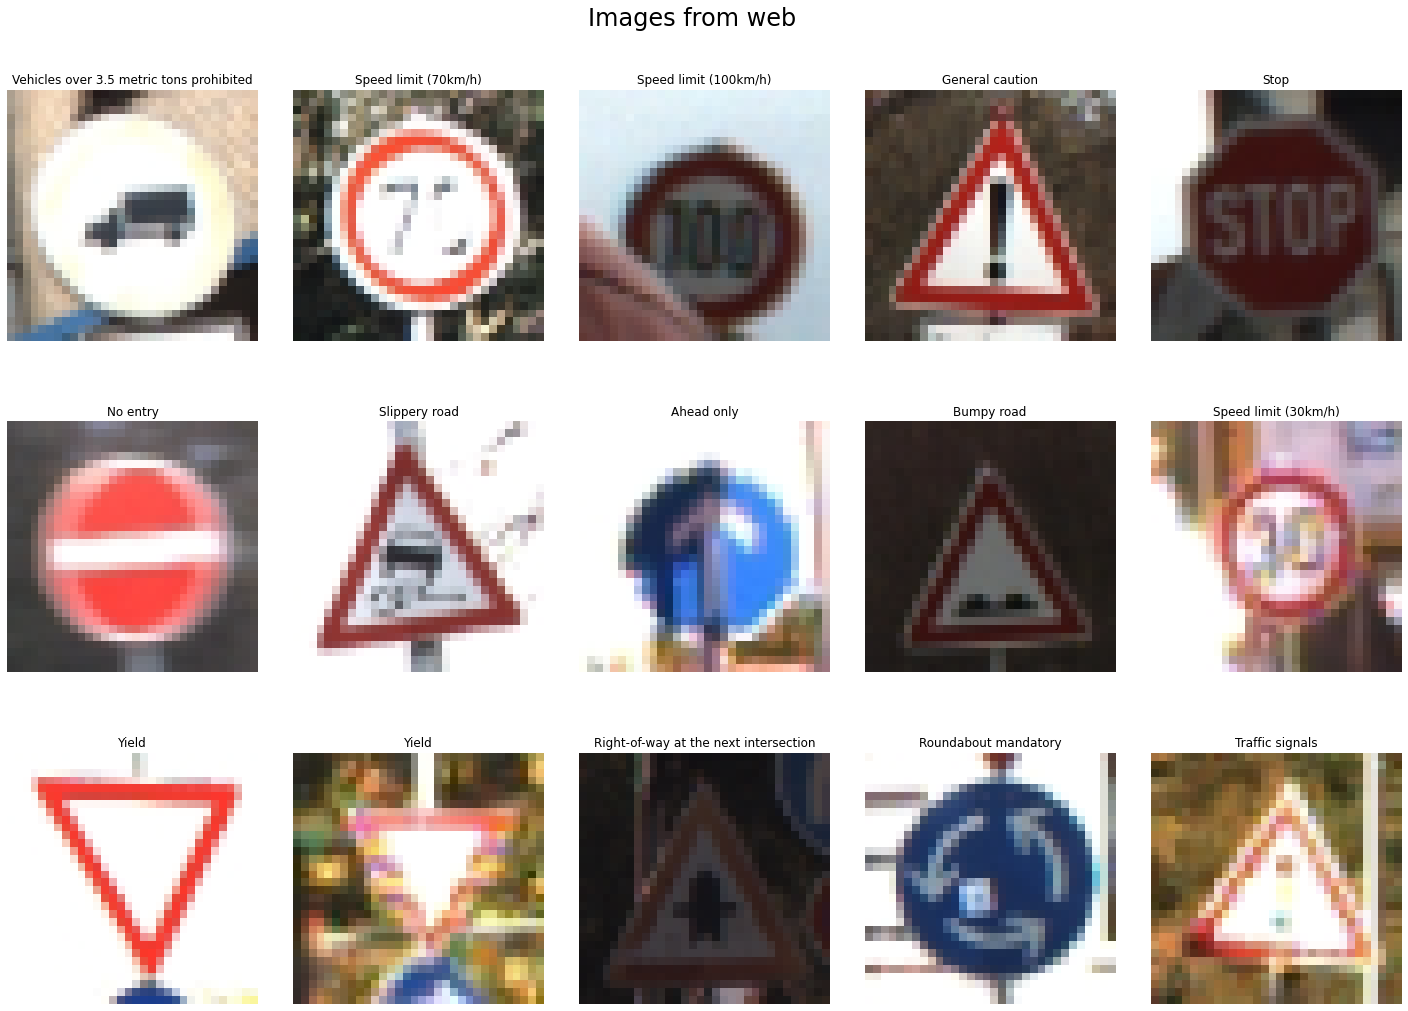

In [73]:
cols = 5
rows = 3
fig = plt.figure(figsize=(20,15))
fig.suptitle('Images from web', fontsize='24');
for i in range(len(new_imgs)):
    ax = fig.add_subplot(rows, cols, i+1)
    ax.imshow(new_imgs[i])
    ax.set_title(signnames_dict[y[i]])
    ax.axis('Off')
fig.tight_layout(rect=[0,0,1,0.96])   
fig.savefig('./writeup_images/web_signs.png')

### Predict the Sign Type for Each Image

Pre-process:

In [55]:

# Normalise
new_imgs_norm = new_imgs / 255

# Center
new_imgs_cent = new_imgs_norm - (np.mean(new_imgs_norm, axis=(1,2,3)))[:, np.newaxis, np.newaxis, np.newaxis]

#Grayscale
new_imgs_gray = np.mean(new_imgs_cent, axis=3)[:,:,:,np.newaxis]

In [56]:
### Run the predictions here and use the model to output the prediction for each image.
tf.reset_default_graph()
saver = tf.train.import_meta_graph('./logs/LeNet_gray_valid-lr=1E-03-e=50-drop=0.5-jit-color-norm.ckpt-49.meta')

with tf.Session() as sess:

    saver.restore(sess, './logs/LeNet_gray_valid-lr=1E-03-e=50-drop=0.5-jit-color-norm.ckpt-49')
    graph = tf.get_default_graph()
    
    with graph.as_default():
        print('TESTING...')
        print()

        softmax, accuracy = sess.run(
            ['probabilities/Softmax:0' ,'accuracy/Mean:0'], 
            feed_dict={'inputs:0': new_imgs_gray, 'labels:0': y, 'drop_prob:0': 0.})
        top5 = sess.run(tf.nn.top_k(softmax, k=5))


#         print('Prediction: {}'.format(signnames_dict[prediction]))
#         print('Test Accuracy: {:.02%}'.format(accuracy))
        prediction = sess.run(tf.argmax(softmax, axis = 1))
        print('Predictions:')
        print('\n'.join('{}: {}'.format(*k) for k in enumerate(prediction)))


TESTING...

Predictions:
0: 16
1: 4
2: 7
3: 18
4: 14
5: 17
6: 23
7: 35
8: 22
9: 1
10: 13
11: 13
12: 11
13: 40
14: 26


Display predictions against images:

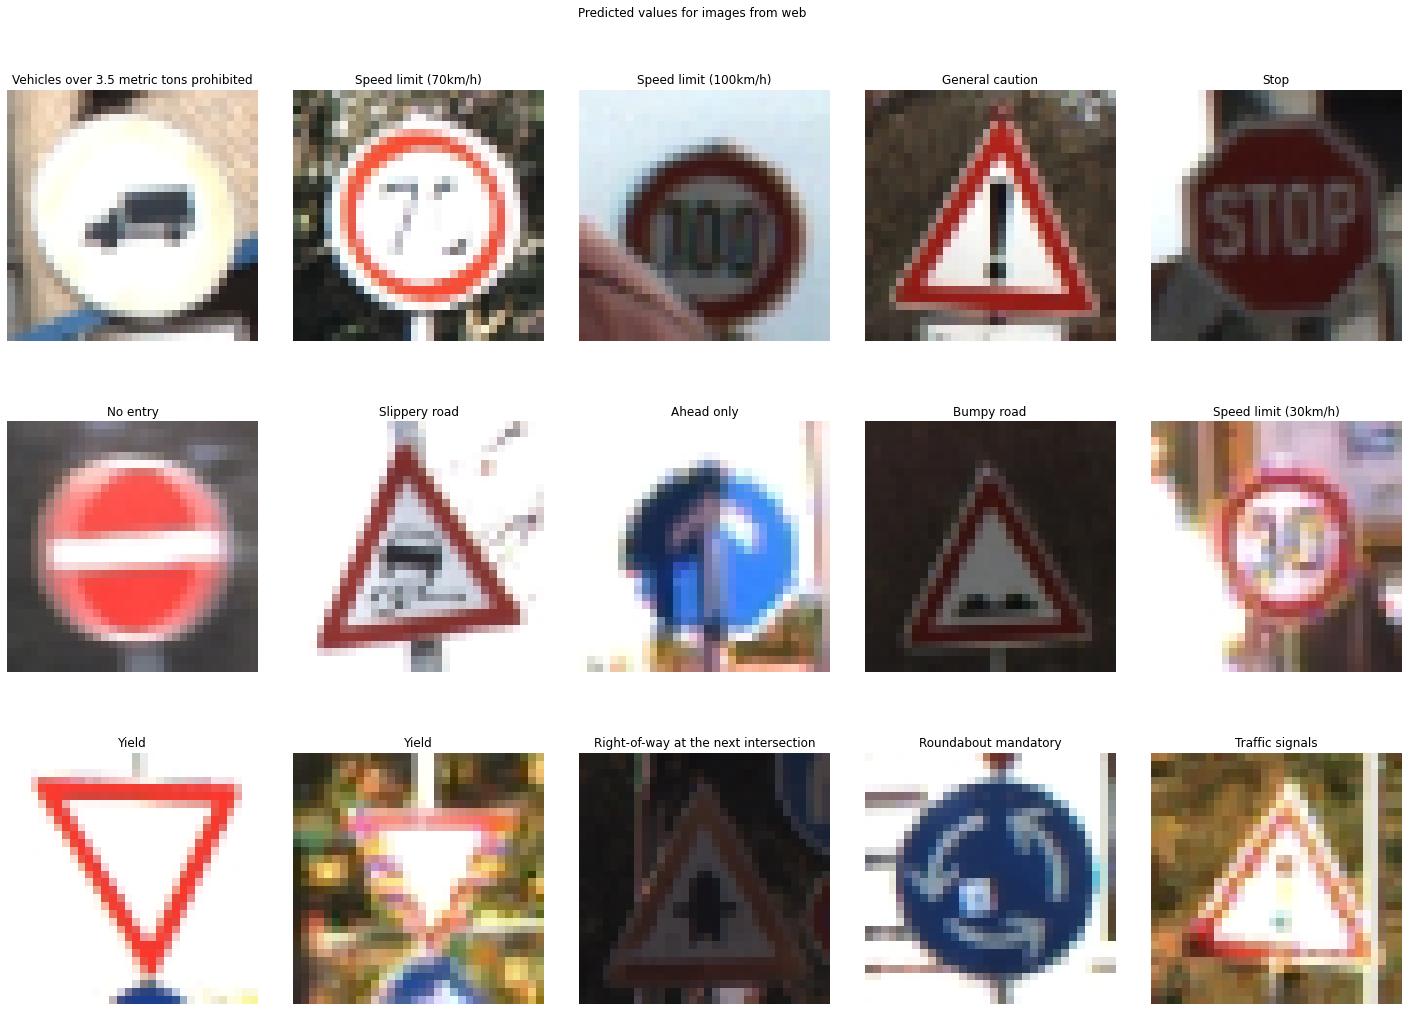

In [74]:
cols = 5
rows = 3
fig = plt.figure(figsize=(20,15))
fig.suptitle('Predicted values for images from web');
for i in range(len(new_imgs)):
    ax = fig.add_subplot(rows, cols, i+1)
    ax.imshow(new_imgs[i])
    ax.set_title(signnames_dict[prediction[i]])
    ax.axis('Off')
fig.tight_layout(rect=[0,0,1,0.96])   
fig.savefig('./writeup_images/test_results.png')

### Analyze Performance

In [58]:
print('Test Accuracy: {:.02%}'.format(accuracy))

Test Accuracy: 100.00%


### Output Top 5 Softmax Probabilities For Each Image Found on the Web

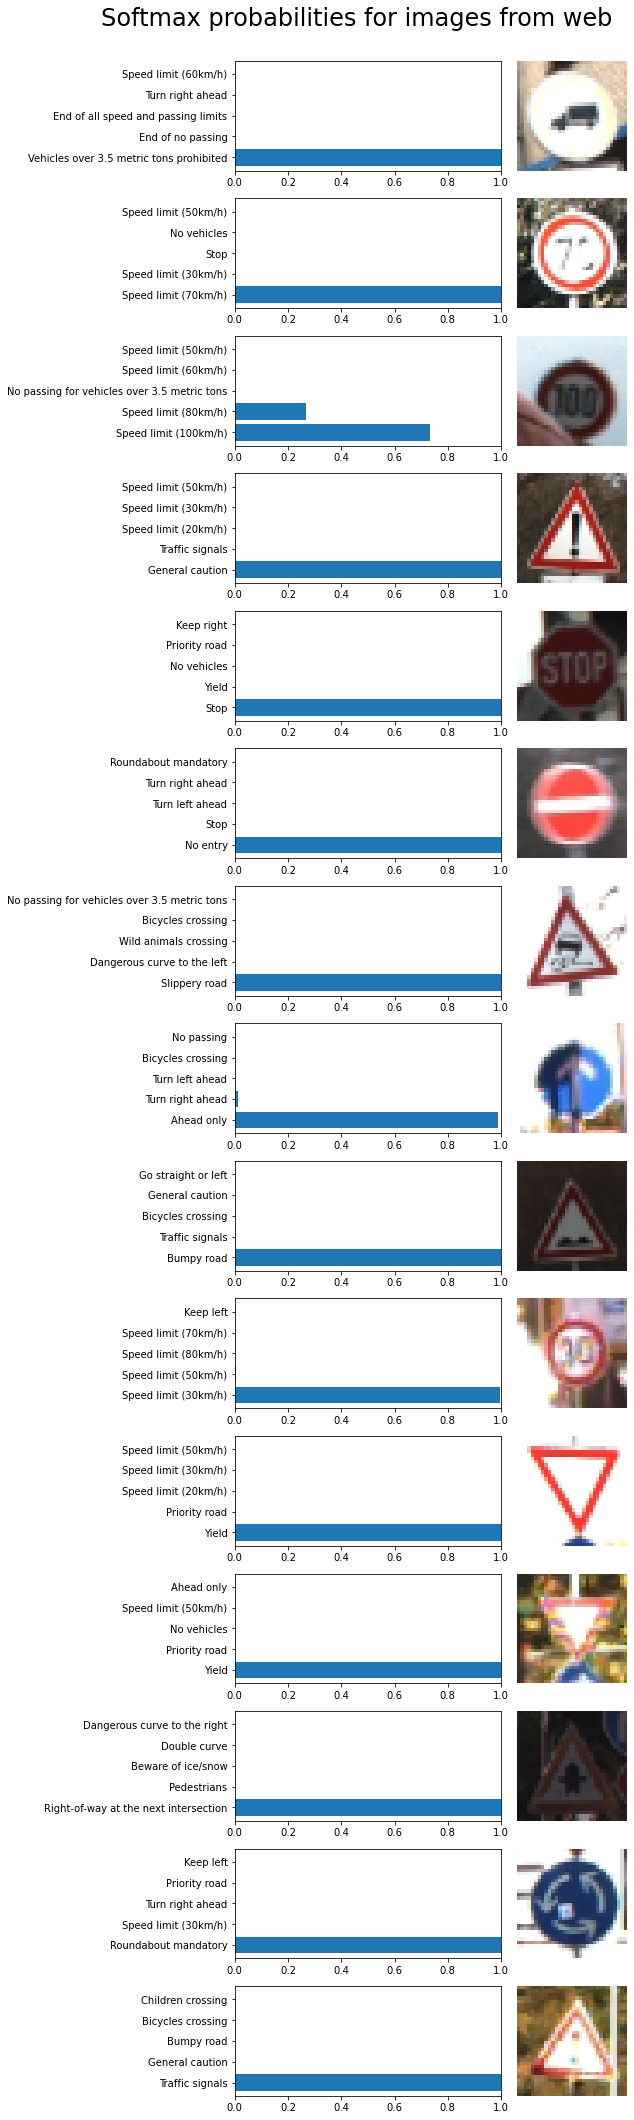

In [145]:
rows = 15
cols = 2
fig = plt.figure(1,figsize=(10,30))
fig.suptitle('Softmax probabilities for images from web', fontsize=24)

for i, img_top5 in enumerate(top5[1]):
    cat = []
    val = []
    for c in img_top5:
        cat.append(signnames_dict[c])
    ax = fig.add_subplot(rows, cols, i*2+1)
    ax.set_xlim([0,1])
    ax.barh(cat, top5[0][i])

for i in range(len(new_imgs)):
    ax = fig.add_subplot(rows, cols, i*2+2)
    ax.imshow(new_imgs[i])
    ax.axis('Off')

fig.tight_layout(rect=[0,0,1,0.96])  
fig.savefig('./writeup_images/softmax.png')

In [59]:
for i, img_top5 in enumerate(top5[1]):
    print('----------------------------------------------------')
    print('Actual: {}'.format(signnames_dict[y[i]]))
    print('Predicted:')
    print(('\n'.join('{:.3%}: {}'.format(top5[0][i][k], signnames_dict[pred]) for k, pred in enumerate(img_top5))))

----------------------------------------------------
Actual: Vehicles over 3.5 metric tons prohibited
Predicted:
100.000%: Vehicles over 3.5 metric tons prohibited
0.000%: End of no passing
0.000%: End of all speed and passing limits
0.000%: Turn right ahead
0.000%: Speed limit (60km/h)
----------------------------------------------------
Actual: Speed limit (70km/h)
Predicted:
100.000%: Speed limit (70km/h)
0.000%: Speed limit (30km/h)
0.000%: Stop
0.000%: No vehicles
0.000%: Speed limit (50km/h)
----------------------------------------------------
Actual: Speed limit (100km/h)
Predicted:
73.143%: Speed limit (100km/h)
26.656%: Speed limit (80km/h)
0.177%: No passing for vehicles over 3.5 metric tons
0.024%: Speed limit (60km/h)
0.001%: Speed limit (50km/h)
----------------------------------------------------
Actual: General caution
Predicted:
100.000%: General caution
0.000%: Traffic signals
0.000%: Speed limit (20km/h)
0.000%: Speed limit (30km/h)
0.000%: Speed limit (50km/h)
------

---

## Step 4: Visualize the Neural Network's State with Test Images

Here is an example of the output of the first convolutional layer of the trainined model. It shows which features of the input image are of interest to the first convulutional layer of the model.

<figure>
    <center><img src="visualize_cnn.png" width="380" alt="Combined Image"/></center>
</figure>
 <p></p> 
